### TORCH.NN

### MNIST 데이터 준비

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [2]:
import pickle # 객체 자체를 파일로 저장
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


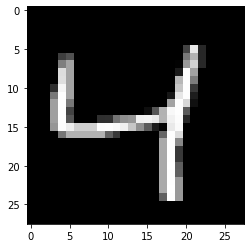

In [3]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[2].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [4]:
import torch

# tensor 형태로 데이터 변환
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

n, c = x_train.shape

print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


### torch.nn 없이 신경망 만들기

In [5]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()

bias = torch.zeros(10, requires_grad=True)

In [6]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1) # unsqueeze() : 특정 위치에 1인 차원 추가

def model(xb):
    return log_softmax(xb @ weights + bias) # @ : dot product

In [7]:
bs = 64  # 배치 사이즈

xb = x_train[0:bs]  # x로부터 미니배치(mini-batch) 추출

preds = model(xb)  # 예측
preds[0], preds.shape

print(preds[0], preds.shape)

tensor([-1.8714, -3.1556, -2.5222, -2.6708, -2.1062, -2.1845, -2.1540, -2.1843,
        -2.2590, -2.4449], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [8]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean() # negative log-likelihood

loss_func = nll

In [9]:
yb = y_train[0:bs]

print(loss_func(preds, yb))

tensor(2.3481, grad_fn=<NegBackward>)


In [10]:
# 정확도 구하기 위한 함수 -> 가장 큰 값의 인덱스가 목표값과 동일하면 예측 잘 된 것
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    
    return (preds == yb).float().mean()

In [11]:
print(accuracy(preds, yb))

tensor(0.0938)


In [ ]:
from IPython.core.debugger import set_trace

lr = 0.5    # 학습률(learning rate)
epochs = 2  # 훈련에 사용할 에폭(epoch) 수

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

> <ipython-input-12-bb1632f37b74>(9)<module>()
      7     for i in range((n - 1) // bs + 1):
      8         set_trace()
----> 9         start_i = i * bs
     10         end_i = start_i + bs
     11         xb = x_train[start_i:end_i]

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
> <ipython-input-12-bb1632f37b74>(8)<module>()
      6 for epoch in range(epochs):
      7     for i in range((n - 1) // bs + 1):
----> 8         set_trace()
      9         start_i = i * bs
     10         end_i = start_i + bs



### torch.nn.functional 사용하기

In [ ]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [ ]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))